In [1]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.legend import Legend
import networkx as nx

random.seed(9)
np.random.seed(9)
torch.manual_seed(9)
torch.cuda.manual_seed(9)

# Toy scenario - random treatment assignment

In [2]:
from causememaybe.toy import DataGeneratingProcess

n_samples = 5000
noise = 0.4
random_state = 9
scale = 2.1 # Influence of latent factor on survival under tested treatment
param_test = {"shape_parameter_alpha":0.3, "scale_parameter_lambda":0.5, "beta":np.array([1, -0.2])}
param_control = {"shape_parameter_alpha":0.6, "scale_parameter_lambda":0.5, "beta":np.array([0.9, -0.1])}

In [3]:
dgp = DataGeneratingProcess(
                            n_samples=n_samples,
                            noise=noise,
                            random_state=random_state,
                            scale=scale,
                            param_test=param_test,
                            param_control=param_control,
                            uniform_censoring=True,
                            random_treatment_assignment=True
                           )

Suppose we have a dataset. Where every patient's continious features are generated according to sklearn's [*make_moons*](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) dataset. The classification label generated from this dataset is treated as a latent(unobserved) binary factor in our case denoted as $G \in \{0, 1\}$ - the idea is that it will confound our results. We plot this dataset below. 

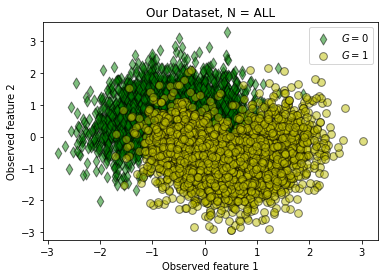

In [4]:
fig, ax = plt.subplots(figsize=(6, 4))
cmap = plt.get_cmap("terrain")
ind0, ind1 = np.where(dgp.latent_binary_confounder == 0), np.where(dgp.latent_binary_confounder == 1)
ax.scatter(dgp.X[ind0,0], dgp.X[ind0, 1], marker="d", label='$G = \\mathdefault{0}$', alpha=0.5, c="g", edgecolors='black', s=60);
scatter = ax.scatter(dgp.X[ind1,0], dgp.X[ind1, 1], marker="o", label='$G = \\mathdefault{1}$', alpha=0.5, c="y", edgecolors='black', s=60);
legend = ax.legend()
ax.set_xlabel("Observed feature 1");
ax.set_ylabel("Observed feature 2");
ax.set_title("Our Dataset, N = ALL");

Suppose the generative process for the survival of the patients (both treated and control) follows [Gompertz distribution](https://en.wikipedia.org/wiki/Gompertz_distribution), where we sample the survival times of patients as follows:

$
Y_{A} = \frac{1}{\alpha_{A}} \log \Big[ 1 - \frac{\alpha_{A} \times \log(U)}{ \lambda_{A} \times \exp(\beta_{A}^{T} X)} \Big] + G * \gamma, U \sim \text{Uniform}(0, 1)
$

where $\alpha_{A} \in \{-\infty, +\infty\}$ and $\lambda_{A} > 0$ are shape and scale parameters respectively. $x$ is the patient's feature vector and $\beta_{A}$ are the true paramters. Subscript $A$ denotes that these paramters are specific to the particular treatment assignment $A \in \{ 0, 1 \}$, where 0 denotes control and 1 denotes test. $Y_{A}$ are the potential outcomes of the corresponding treatment. $\gamma$ is a predefined parameter `scale` that defines the contribution of $G$ to the survival (remember that $G \in \{0, 1 \}$).

We plot the distribution of potential survival times for both $A=1$ and $A=0$ below.

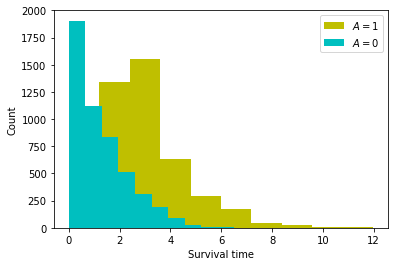

In [5]:
Y_1 = dgp.sample_outcomes("test")
Y_0 = dgp.sample_outcomes("control")
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(Y_1, label="$A = \\mathdefault{1}$", color="y");
ax.hist(Y_0, label="$A = \\mathdefault{0}$", color="c");
ax.legend();
ax.set_xlabel("Survival time");
ax.set_ylabel("Count");

We also need to specify an underlying survival times generating process. Broadly these can be informative and uninformative censoring times. In our case we assume uninformative censoring times, that are generated from a uniform distribtuion:

$
C \sim \text{Uniform}(0.5, 16)
$

Given that above we have specified that in this case treatment assignment is random

$
A \sim \text{Bernouli}(0.5)
$

we have the following plot that where marker shape shows latent variable value and color shows treatment assignment

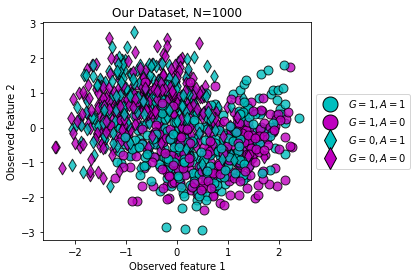

In [6]:
sample_size = 1000

fig, ax = plt.subplots(figsize=(6, 4))
for i in range(sample_size):
    t = dgp.treatment[i]
    c = "c" if t==1 else "m"
    m = "o" if dgp.latent_binary_confounder[i] == 1 else "d" 
    ax.scatter(dgp.X[i,0], dgp.X[i, 1], marker=m, alpha=0.8, c=c, edgecolors='black', s=80);

combs = [
    ("c", "o", "$G = \\mathdefault{1}, A = \\mathdefault{1}$"),
    ("m", "o", "$G = \\mathdefault{1}, A = \\mathdefault{0}$"),
    ("c", "d", "$G = \\mathdefault{0}, A = \\mathdefault{1}$"),
    ("m", "d", "$G = \\mathdefault{0}, A = \\mathdefault{0}$")
    ]
    
handles = [Line2D([0], [0], color=c, marker=m, lw=0, 
                          markersize=15, label=l, markeredgecolor='black') for c, m, l in combs]
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_xlabel("Observed feature 1");
ax.set_ylabel("Observed feature 2");
ax.set_title("Our Dataset, N={}".format(sample_size));

then observed survival time $Y$ and censoring indiciator $\delta$ are defined as:

$
Y = \min(Y_{A}, C) \text{,   } \delta = 1 \text{ if } Y_{A} < C, \text{ else } \delta = 0
$

dependent on the assigned treatment $A$. If suppose $A=1$ then $Y_{1}$ is a factual outcome, which however might be hidden behind $C$.

### Data generation process recap

To recap we have the following: 

Observed features and latent binary factor generated from make moons function,

$
X, G \sim \text{sklearn make moons}
$

Random treatment assignment,

$
A \sim \text{Bernouli}(0.5)
$

Given the treatment assignment we generate factual survival time $Y_A$,

$
Y_{A} = \frac{1}{\alpha_{A}} \log \Big[ 1 - \frac{\alpha_{A} \times \log(U)}{ \lambda_{A} \times \exp(\beta_{A}^{T} x)} \Big], U \sim \text{Uniform}(0, 1)
$

and censoring time that is independent of everything else


$
C \sim \text{Uniform}(0.5, 16)
$

which leads to observed time interval $Y$ and censoring indicator $\delta$

$
Y = \min \big( [AY_{A=1} + (1-A)Y_{A=0}], C \big) \text{,   } \delta = 1 \text{ if } Y_{A} < C, \text{ else } \delta = 0
$

### Causal graph

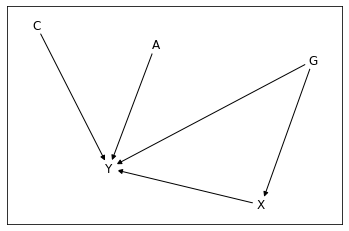

In [19]:
G = nx.DiGraph(directed=True)
G.add_edges_from(
    [('G', 'X'), ('G', 'Y'), ('C', 'Y'), ('X', 'Y'), ('A', 'Y')])
nx.draw_networkx(G, arrows=True, node_color="white")

### Potential outcomes framework

The overall framework and notation we adopted above is referred to as _potential outcomes framework_ for modeling causal effects in observational and experimental studies. In our case we have a "subject" with continious features $X \in \mathcal{X}$, and unobserved categorical feature $G \in \{0, 1\}$. A subject could be a patient in the medical experiment or observational data, or an app user on facebook's platform. $A \in \{0, 1\}$ denotes a treatment variable, in this case we have only two treatment options: $A=0$ for no treatment, or control; and $A=1$ to indicate that a subject has been assigned to a treatment (e.g. new feature in an app, or hemeotherapy for a patient). The outcome variable $Y \in \mathbb{R}^{+}$, is the survival time that we have actually observed in the experiment for a particular subject. The observed outcome $Y$ takes on values of either of the two "potential outcomes" $Y_{A=1}$ or $Y_{A=0}$ which depends on the value that $A$ takes, unless cenosring time $C$ has happened earlier than the potential outcome $Y_{A}$, hence $Y = \min \big( [AY_{A=1} + (1-A)Y_{A=0}], C \big)$.

When working with observational data or data from a randomized control trials, we tipycally are given $N$ samples of the tuples $Z = (X, A, Y)$ (forgetting for a second that we may have some unobserved confounders $U$, in our case binary variable $G$). Samples $Z$ are drawn from some underlying probability distribution with paramters $\theta$

$
Z_1, ..., Z_n \sim \mathbb{P}_{\theta}
$

We may further breakdown $\theta$ into a collection a _nuissance_ paramters (paramters that are not of imediate interest but need to be accounted for):

$
\theta = \{ \mu_{A=1}, \mu_{A=0}, \pi, \eta \}
$

where $\mu_{A=1}(x) = \mathbb{E}[Y_{A=1}|X=x]$ and $\mu_{A=0}(x) = \mathbb{E}_{\theta}[Y_{A=0}|X=x]$ are conditional potential outcomes for a subject with features $x$. and $\pi$ is the treatment assignment mechanism,

$
\pi(x)= \mathbb{P}_\theta (A = 1 | X = x)
$

and $\eta(x) = \mathbb{P}_\theta (X=x)$. 

In the simulation above we have access to each of the steps of the data generative process, and we know that the treatment assignment is random.

Our goal is then to use causal inference techniques to infer the treatment effects function $\tau(X)$ of individual subjects based on their features using the samples $\{ Z_i \}^{N}_{i=1}$. The treatment effect function is defined as $\tau(X) = \mathbb{E}[Y_{A=1} - Y_{A=1} | X] = \mu_{A=1}(x) - \mu_{A=0}(x)$, known as Individual Treatment Effect (ITE). Our causal model $M$ maps a dataset $\{ Z_i \}^{N}_{i=1}$ to an estimate $\hat{\tau}(.)$ of ITE. The accuracy of the model is charaterised by the squarred-$L^2$ loss:

$
\epsilon_{PEHE} = || \hat{\tau}(X) - \tau(X) ||^{2}_\theta \approx \frac{1}{N} \sum^{N}_{n=1} || \hat{\tau}(X=x_n) - \tau(X=x_n) ||^{2}_\theta
$

also known as Precision of Estimating Heterogeneous Effects (PEHE), where $||f(X)||^{2}_\theta = \mathbb{E}_{\theta}[f^{2}(X)]$. Note that to estimate PEHE one has to have access to factual and counterfactual outcomes and their generative distribution, so that their expectations of the outcomes can be compared.

### Coming back to our example

Coming back to our example, we can see the overall dataset

In [7]:
dgp.df.head(n=10)

,x0,x1,latent_binary_confounder,treatment_assignment,true_treatment_prob,mu_test,mu_control,y_test,y_control,c,observed,delta
0,0.092825,2.005091,0,0,0.5,1.730574,1.215252,5.180093,0.818347,5.780297,0.818347,0
1,-1.702977,-1.352574,0,0,0.5,3.494396,2.478149,3.351029,0.960817,3.855242,0.960817,0
2,0.333258,-0.996604,1,1,0.5,3.016217,0.860140,2.836214,0.833438,6.959917,2.836214,0
3,-0.664376,1.463726,0,1,0.5,2.635945,1.751538,4.737672,1.526734,12.142476,4.737672,0
4,-0.034271,0.325614,0,1,0.5,1.486772,1.178020,2.766241,0.114690,12.437605,2.766241,0
5,1.037789,-0.143298,0,1,0.5,0.581047,0.569618,0.910460,0.357504,10.629290,0.910460,0
6,-0.302508,-0.032776,1,1,0.5,3.821416,1.342293,3.873922,2.106191,4.096317,3.873922,0
7,0.335954,-1.396876,1,1,0.5,2.953712,0.815393,3.343178,1.663275,5.786195,3.343178,0
8,0.455208,0.861212,0,0,0.5,1.108781,0.903343,2.504046,0.327691,8.056380,0.327691,0
9,0.611054,-0.248606,0,1,0.5,0.827451,0.758951,0.948892,2.052378,2.213738,0.948892,0


We can see our continious features $X$ as `x0` and `x1`; latent confounder $G$ as `latent_binary_confounder`; treatment assignment indicator; conditional potential outcomes $\mu_{A=1}(x)$ and $\mu_{A=0}(x)$ denoted as `mu_test` and `mu_control`; and the corresponding sampled potential outcomes `y_test` and `y_control`, censoring time `c` and the observed time `observed` and the censoring indicator `delta`.

In [12]:
print("% of treated subjects: {}".format(dgp.df.treatment_assignment.sum()/len(dgp.df)*100))
print("% of censored subjects: {}".format(dgp.df.delta.sum()/len(dgp.df)*100))

% of treated subjects: 49.46
% of censored subjects: 11.26


Given the access to conditional potential outcomes `mu_test` $\mu_{A=1}(x)$ and `mu_control` $\mu_{A=0}(x)$ we can compute the true ITE $\tau(X) = \mu_{A=1}(x) - \mu_{A=0}(x)$

In [24]:
PEHE_true = np.sum((dgp.df.mu_test - dgp.df.mu_control)**2) / len(dgp.df)
print("True PEHE: {:.3f}".format(PEHE_true))

True PEHE: 2.988
